<a href="https://colab.research.google.com/github/bhattacharjee/msc-ai-project/blob/main/iteration_3.0.ipynb/Autoencoder_iteration_3.4_invert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
auc_scores = {}
N_EPOCHS = 50
#INVERT_TRAIN_TEST = False # If False, train with encrypted and test with non-encrypted
INVERT_TRAIN_TEST = True # If False, train with encrypted and test with non-encrypted
LOSS_FUNCTION='mse'   # mse or binary_crossentropy

RANDOM_SEED = 42

In [2]:
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging, sys, random, glob
from google.colab import drive
from functools import lru_cache
import sklearn
from sklearn.model_selection import train_test_split

from tensorflow import keras as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import IPython

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


drive.mount("/content/drive")

def set_random_seed():
    np.random.seed(1)
    random.seed(1)
    tf.random.set_seed(1)

root = logging.getLogger()
root.setLevel(logging.INFO)
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

!if [[ -d /content/drive/MyDrive/MSCPROJDATA ]]; then cp -r /content/drive/MyDrive/MSCPROJDATA .; fi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def get_columns(thisdf):
    baseline_columns = [c for c in thisdf.columns if c.startswith('baseline') and "head" not in c and "tail" not in c]
    baseline_columns = [c for c in baseline_columns if "filesize" not in c]
    baseline_columns = [c for c in baseline_columns if "begin" not in c and "end" not in c]

    advanced_columns = [c for c in thisdf.columns if "advanced" in c]
    advanced_columns = [c for c in advanced_columns if "begin" not in c and "end" not in c]
    advanced_columns = [c for c in advanced_columns if "head" not in c and "tail" not in c]
    advanced_columns = [c for c in advanced_columns if "start" not in c]
    advanced_columns_only = list(set(advanced_columns))
    advanced_columns = list(set(advanced_columns + baseline_columns))

    fourier_columns = [c for c in thisdf.columns if "fourier" in c and "value" not in c]
    fourier_columns = [c for c in fourier_columns if "1byte" in c]
    fourier_columns = [c for c in fourier_columns if "begin" not in c and "end" not in c]
    fourier_columns = [c for c in fourier_columns if "head" not in c and "tail" not in c]
    fourier_columns = [c for c in fourier_columns if "start" not in c]
    fourier_columns_only = list(set(fourier_columns))
    fourier_columns = list(set(advanced_columns + fourier_columns))
    
    baseline_and_advanced = list(set(baseline_columns + advanced_columns_only))
    baseline_and_fourier = list(set(baseline_columns + fourier_columns_only))
    advanced_and_fourier = list(set(advanced_columns_only + fourier_columns_only))

    all_columns = [c for c in thisdf.columns]
    
    return {\
        "baseline": baseline_columns,\
        "advanced-only": advanced_columns_only,\
        "fourier-only": fourier_columns_only,\
        "baseline-and-fourier": baseline_and_fourier,\
        "advanced-and-fourier": advanced_and_fourier,\
        "advanced": advanced_columns,\
        "fourier": fourier_columns,\
        "all_columns": all_columns,
    }

# @lru_cache(maxsize=5)
def load_datasets_once():
    """Load all datasets only once
    
    We want to load the datasets only once. Once loaded
    serve from cache
    """
    datasets = dict()
    for file in glob.glob("MSCPROJDATA/**.parquet.gz", recursive=True):
        if not file.startswith("MSCPROJDATA/n1"):
            print(f"Loading {file}")
            df = pd.read_parquet(file)
            df = df.sample(frac=1).reset_index(drop=True)
            df["is_encrypted"] = 1 if "encr" in file.lower() else 0
            datasets[file] = df
    return datasets
    
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [4]:
temp_all_dfs = load_datasets_once()
temp_all_dfs['MSCPROJDATA/plaintext.base32.combined.parquet.gz'].columns

all_column_names = get_columns(temp_all_dfs['MSCPROJDATA/plaintext.base32.combined.parquet.gz'])
print(all_column_names.keys())
temp_all_dfs = None

import gc
def gc_collect():
    [gc.collect(i) for i in range(3) for j in range(3)]

gc_collect()

Loading MSCPROJDATA/plaintext.base32.combined.parquet.gz
Loading MSCPROJDATA/plaintext.expanded.parquet.gz
Loading MSCPROJDATA/expanded.plaintext.base32.parquet.gz
Loading MSCPROJDATA/plaintext.combined.parquet.gz
Loading MSCPROJDATA/expanded.pyencrypted_v1.b32.parquet.gz
Loading MSCPROJDATA/expanded.pyencrypted_v2.base32.parquet.gz
Loading MSCPROJDATA/expanded.pyencrypted_v1.parquet.gz
Loading MSCPROJDATA/expanded.pyencrypted_v2.parquet.gz
dict_keys(['baseline', 'advanced-only', 'fourier-only', 'baseline-and-fourier', 'advanced-and-fourier', 'advanced', 'fourier', 'all_columns'])


In [5]:
all_column_names.keys()

dict_keys(['baseline', 'advanced-only', 'fourier-only', 'baseline-and-fourier', 'advanced-and-fourier', 'advanced', 'fourier', 'all_columns'])

In [6]:
all_datasets = load_datasets_once()
full_dataset = pd.concat(all_datasets.values())
full_dataset = full_dataset.fillna(0.0)

if not INVERT_TRAIN_TEST:
    encrypted_df = full_dataset[full_dataset["is_encrypted"] == 1]
    non_encrypted_df = full_dataset[full_dataset["is_encrypted"] == 0]
else:
    encrypted_df = full_dataset[full_dataset["is_encrypted"] == 0]
    non_encrypted_df = full_dataset[full_dataset["is_encrypted"] == 1]

discard_some = True
if discard_some:
    retain = full_dataset['extended.base_filename'].map(lambda x: ".webp" not in x and "b32" not in x and "base32" not in x)
    full_dataset = full_dataset[retain]

# shuffle
encrypted_df = encrypted_df.sample(frac=1).reset_index(drop=True)
non_encrypted_df = non_encrypted_df.sample(frac=1).reset_index(drop=True)

columns = all_column_names["all_columns"]
print(f"Number of features in full dataset: {len(columns)}")

work_encrypted_df_X = encrypted_df[columns]
work_encrypted_df_y = encrypted_df["is_encrypted"]
work_non_encrypted_df_X = non_encrypted_df[columns]
work_non_encrypted_df_y = non_encrypted_df["is_encrypted"]


columns = []
for i, j in zip(work_encrypted_df_X.dtypes, work_encrypted_df_X.columns):
    if "float" in str(i):
        columns.append(j)

work_encrypted_df_X = work_encrypted_df_X[columns]
work_non_encrypted_df_X = work_non_encrypted_df_X[columns]

import gc
del all_datasets
del encrypted_df
del non_encrypted_df
for i in range(3):
    for j in range(3):
        gc.collect(j)
        gc.collect(i)

def normalize_df(X, Y):
    mindf = X.min()
    maxdf = X.max()
    print(mindf.shape)
    X = (X - mindf) / (maxdf - mindf)
    Y = (Y - mindf) / (maxdf - mindf)
    return X, Y

work_encrypted_df_X, work_non_encrypted_df_X = \
    normalize_df(
        work_encrypted_df_X,
        work_non_encrypted_df_X
    )

gc_collect()

Loading MSCPROJDATA/plaintext.base32.combined.parquet.gz
Loading MSCPROJDATA/plaintext.expanded.parquet.gz
Loading MSCPROJDATA/expanded.plaintext.base32.parquet.gz
Loading MSCPROJDATA/plaintext.combined.parquet.gz
Loading MSCPROJDATA/expanded.pyencrypted_v1.b32.parquet.gz
Loading MSCPROJDATA/expanded.pyencrypted_v2.base32.parquet.gz
Loading MSCPROJDATA/expanded.pyencrypted_v1.parquet.gz
Loading MSCPROJDATA/expanded.pyencrypted_v2.parquet.gz
Number of features in full dataset: 676
(668,)


In [7]:
import sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(\
        work_encrypted_df_X,
        work_encrypted_df_y,
        test_size=0.33,
        random_state=42)

X_train.shape

(216686, 668)

In [8]:
def print_and_plot(model):
    print(model.summary())
    plot = tf.keras.utils.plot_model(
        model,
        show_shapes=True,
        expand_nested=True)
    IPython.display.display(plot)


from sklearn.model_selection import train_test_split
def create_and_train_autoencoder(X, y, model, n_epochs):
    X_train, X_eval, y_train, y_eval= \
        train_test_split(X, y, test_size=0.2, random_state=42)

    nn = model
    nn.compile(optimizer='adam', loss=LOSS_FUNCTION, metrics=["mae", "mse"])

    nn.build((None, X.shape[1]))
    print_and_plot(nn)

    print(X_train.shape, X_eval.shape)
    history = nn.fit(X_train, X_train,
                epochs=n_epochs,
                validation_data=(X_eval, X_eval),
                batch_size=32)
    return nn, history


def evaluate_model(model, columns:list, n_epochs:int, description:str):
    tf.random.set_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    c1 = set([c for c in work_encrypted_df_X.columns])
    c2 = set(columns)
    columns = c1.intersection(c2)
    print(f"Number of features: {len(columns)}")

    # Encrypted section, use half for training, we will use the remaining
    # half for testing
    temp_work_encrypted_df_X = work_encrypted_df_X[columns]
    temp_work_non_encrypted_df_X = work_non_encrypted_df_X[columns]

    nn = model

    columns = []
    for i, j in zip(temp_work_encrypted_df_X.dtypes, temp_work_encrypted_df_X.columns):
        if "float" in str(i):
            columns.append(j)
    temp_work_encrypted_df_X = temp_work_encrypted_df_X[columns]
    temp_work_non_encrypted_df_X = temp_work_non_encrypted_df_X[columns]

    eTrain_X, eTest_X, eTrain_y, eTest_y = \
        train_test_split(\
                        temp_work_encrypted_df_X,\
                        work_encrypted_df_y,\
                        test_size=0.2,\
                        random_state=42)

    nn, history = create_and_train_autoencoder(eTrain_X, eTrain_y, model, n_epochs)

    _, neTest_X, _, neTest_y = \
        train_test_split(\
                        temp_work_non_encrypted_df_X,\
                        work_non_encrypted_df_y,\
                        test_size=0.2,\
                        random_state=42)

    final_test_X = pd.concat([eTest_X, neTest_X])
    final_test_y = pd.concat([eTest_y, neTest_y])

    # ---------------------
    plt.rcParams["figure.figsize"] = (6, 3)
    
    plt.rcParams["figure.figsize"] = (12, 6)
    for metric in ["loss", "mse", "mae"]:
        keys = []
        for k, v in history.history.items():
            if metric in k.lower():
                keys.append(k)
                plt.plot(v, label=k)
            plt.legend(keys)
        plt.show()

    # ----------------------------

    plt.rcParams["figure.figsize"] = (12, 6)
    def get_mse_mae(X, X1):
        saveX, saveX1 = X, X1
        if not isinstance(X, np.ndarray):
            X = X.to_numpy()
        if not isinstance(X1, np.ndarray):
            X1 = X1.to_numpy()
        square_error = np.square(X - X1)
        mse = np.mean(square_error, axis=1)
        abs_error = np.square(X - X1)
        mae = np.mean(abs_error, axis=1)
        return mse, mae
    
    
    
    reconstructed_test_X = nn.predict(final_test_X)
    mse, mae = get_mse_mae(final_test_X, reconstructed_test_X)
    
    
    df_result = pd.DataFrame(\
        {\
            "is_encrypted": final_test_y,\
            "mse": mse,\
            "mae": mae,\
        }\
    )
    
    #df_result2 = df_result[df_result["mae"] < 0.1]

    def show_strip_plot(df_result):
        x_text = "is_encrypted"
        #if not INVERT_TRAIN_TEST:
        #    x_text = "is_encrypted"
        #else:
        #    x_text = "is_encrypted"
        df_result2 = df_result.copy()
        #if INVERT_TRAIN_TEST:
        #    df_result2.rename(columns={"is_encrypted": "is_plaintext"}, inplace=True)
        sns.stripplot(data=df_result2, x=x_text, y="mse", jitter=0.5, size=0.7).set(title="Mean Square Error")
        plt.gca().set_yscale('log')
        plt.show()
        sns.boxplot(data=df_result2, x=x_text, y="mse").set(title="Mean Square Error")
        
        plt.gca().set_yscale('log')
        plt.show()
    
    show_strip_plot(df_result)

    df = df_result
    df = df.sort_values(by="mse").reset_index()
    y_pred = np.log(df["mse"].to_numpy())
    y_true = df["is_encrypted"].to_numpy()
    
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true=y_true, y_score=y_pred)
    auc_score = auc(fpr, tpr)
    print()
    print()
    plt.plot(fpr, tpr)
    print()
    print()
    print(f"AUC Score for {description} is : {auc_score}")

    return description, auc_score

Number of features: 668
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 668)               446892    
                                                                 
 dropout (Dropout)           (None, 668)               0         
                                                                 
 dense_1 (Dense)             (None, 668)               446892    
                                                                 
 dropout_1 (Dropout)         (None, 668)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               342528    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (No

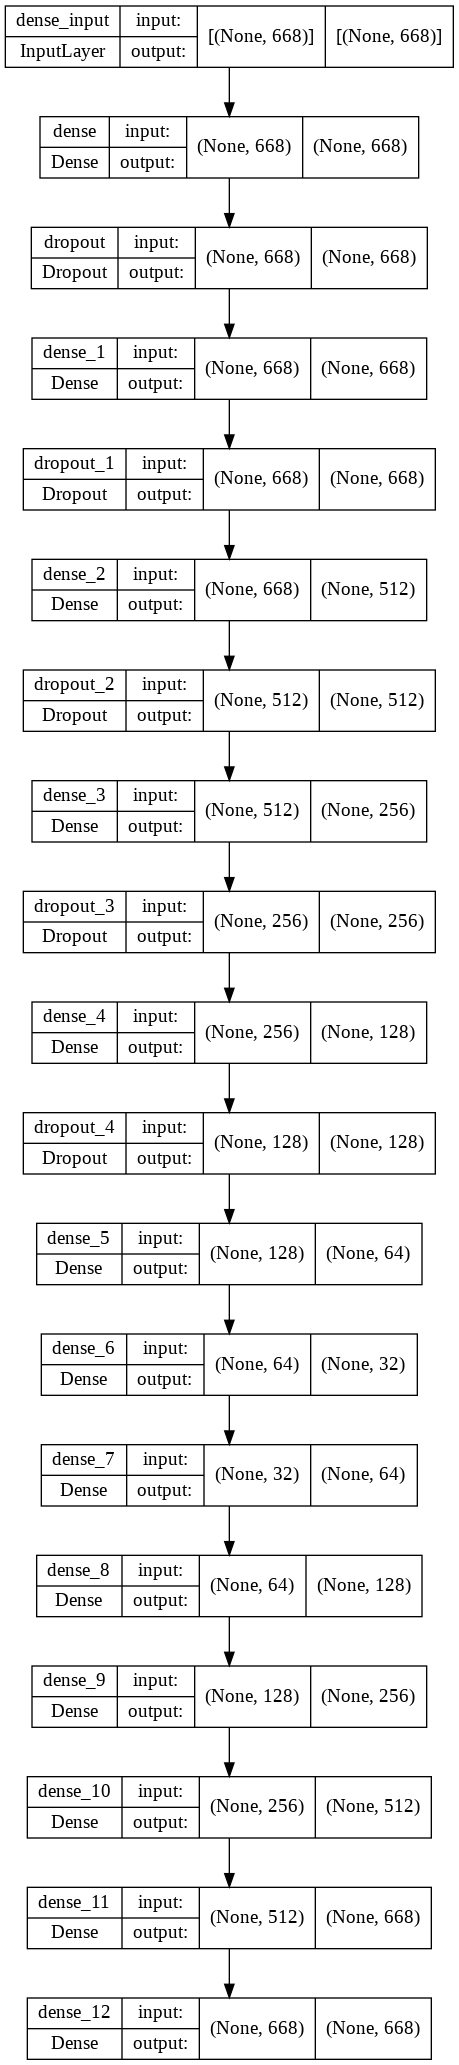

(206983, 668) (51746, 668)
Epoch 1/50
6469/6469 [==============================] - 34s 5ms/step - loss: 0.0057 - mae: 0.0275 - mse: 0.0057 - val_loss: 0.0028 - val_mae: 0.0193 - val_mse: 0.0028
Epoch 2/50
6469/6469 [==============================] - 30s 5ms/step - loss: 0.0027 - mae: 0.0184 - mse: 0.0027 - val_loss: 0.0024 - val_mae: 0.0157 - val_mse: 0.0024
Epoch 3/50
6469/6469 [==============================] - 29s 5ms/step - loss: 0.0023 - mae: 0.0151 - mse: 0.0023 - val_loss: 0.0021 - val_mae: 0.0135 - val_mse: 0.0021
Epoch 4/50
6469/6469 [==============================] - 29s 5ms/step - loss: 0.0019 - mae: 0.0128 - mse: 0.0019 - val_loss: 7.2051e-04 - val_mae: 0.0109 - val_mse: 7.2051e-04
Epoch 5/50
6469/6469 [==============================] - 29s 5ms/step - loss: 7.2742e-04 - mae: 0.0106 - mse: 7.2742e-04 - val_loss: 6.6327e-04 - val_mae: 0.0101 - val_mse: 6.6327e-04
Epoch 6/50
6469/6469 [==============================] - 29s 5ms/step - loss: 6.4711e-04 - mae: 0.0098 - mse: 6.471

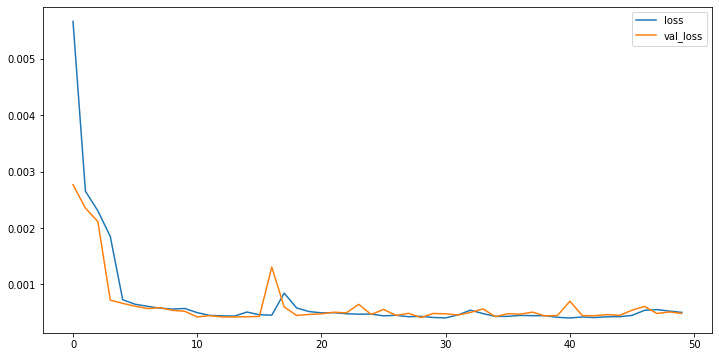

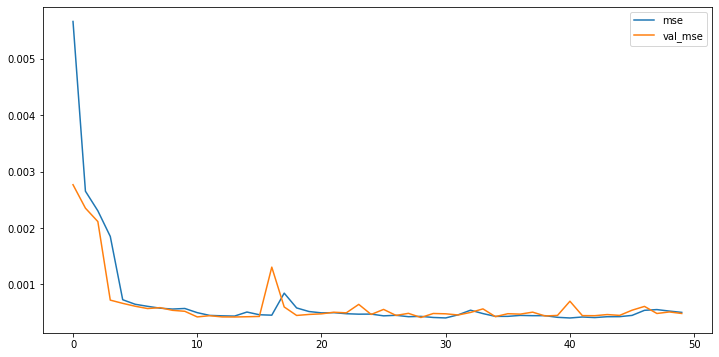

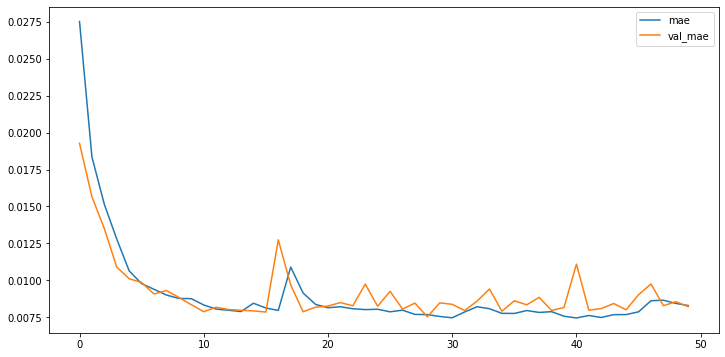

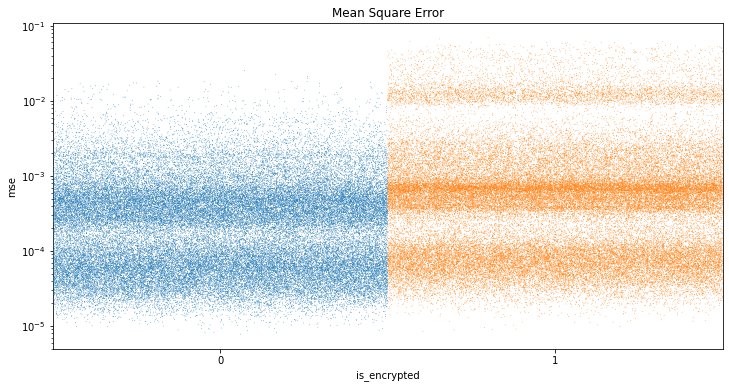

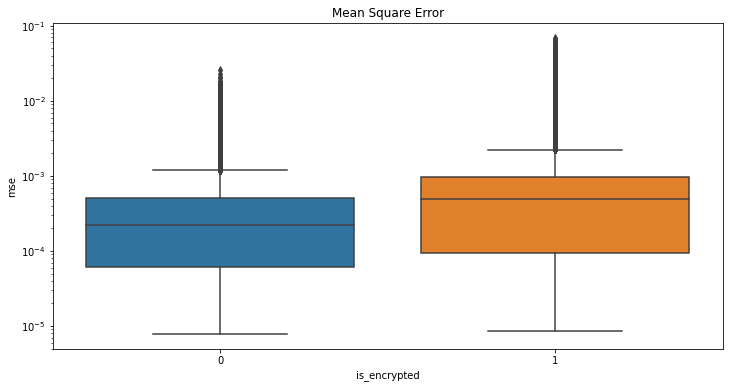





AUC Score for All columns is : 0.6366761240533033


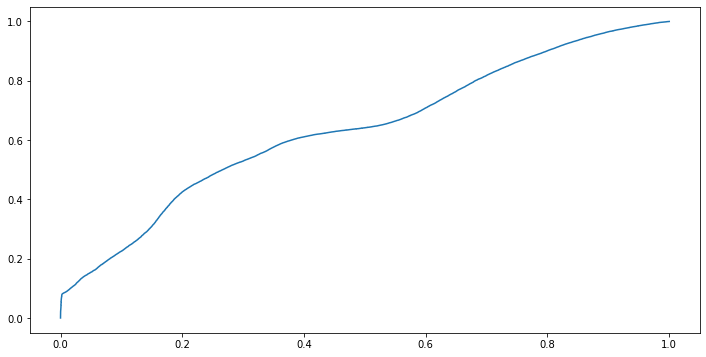

In [9]:
class Autoencoder_AllColumns:
    @staticmethod
    def build():
        model = tf.keras.Sequential(
            [
                layers.Dense(668, activation='relu'),
                layers.Dropout(0.25),
                layers.Dense(668, activation='relu'),
                layers.Dropout(0.25),
                layers.Dense(512, activation='relu'),
                layers.Dropout(0.1),
                layers.Dense(256, activation='relu'),
                layers.Dropout(0.1),
                layers.Dense(128, activation='relu'),
                layers.Dropout(0.05),
                layers.Dense(64, activation='relu'),
                layers.Dense(32, activation='relu'),
                layers.Dense(64, activation='relu'),
                layers.Dense(128, activation='relu'),
                layers.Dense(256, activation='relu'),
                layers.Dense(512, activation='relu'),
                layers.Dense(668, activation='relu'),
                layers.Dense(668, activation='relu'),
            ]
        )
        return model


description, score = evaluate_model(Autoencoder_AllColumns.build(), all_column_names['all_columns'], N_EPOCHS, "All columns")
auc_scores[description] = score

Number of features: 4
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 4)                 20        
                                                                 
 dense_14 (Dense)            (None, 3)                 15        
                                                                 
 dense_15 (Dense)            (None, 2)                 8         
                                                                 
 dense_16 (Dense)            (None, 3)                 9         
                                                                 
 dense_17 (Dense)            (None, 4)                 16        
                                                                 
 dense_18 (Dense)            (None, 4)                 20        
                                                                 
Total params: 88
Trainable param

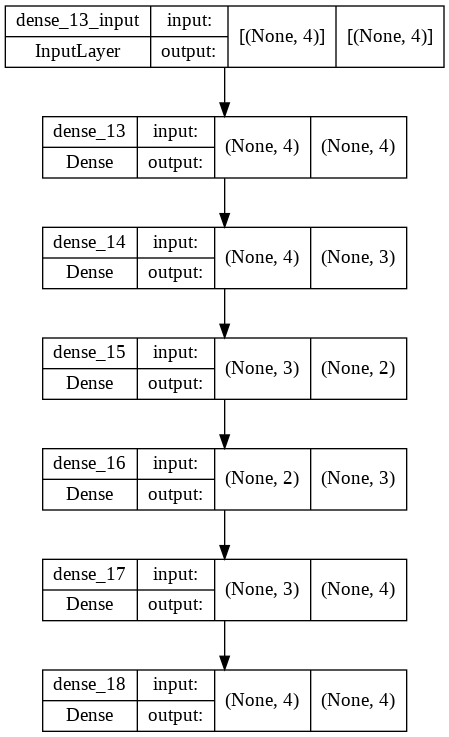

(206983, 4) (51746, 4)
Epoch 1/50
6469/6469 [==============================] - 21s 3ms/step - loss: 0.0063 - mae: 0.0386 - mse: 0.0063 - val_loss: 0.0012 - val_mae: 0.0171 - val_mse: 0.0012
Epoch 2/50
6469/6469 [==============================] - 20s 3ms/step - loss: 0.0011 - mae: 0.0165 - mse: 0.0011 - val_loss: 0.0010 - val_mae: 0.0169 - val_mse: 0.0010
Epoch 3/50
6469/6469 [==============================] - 20s 3ms/step - loss: 0.0010 - mae: 0.0158 - mse: 0.0010 - val_loss: 0.0010 - val_mae: 0.0154 - val_mse: 0.0010
Epoch 4/50
6469/6469 [==============================] - 20s 3ms/step - loss: 0.0010 - mae: 0.0158 - mse: 0.0010 - val_loss: 0.0010 - val_mae: 0.0159 - val_mse: 0.0010
Epoch 5/50
6469/6469 [==============================] - 20s 3ms/step - loss: 9.9803e-04 - mae: 0.0158 - mse: 9.9803e-04 - val_loss: 0.0010 - val_mae: 0.0160 - val_mse: 0.0010
Epoch 6/50
6469/6469 [==============================] - 20s 3ms/step - loss: 9.9655e-04 - mae: 0.0158 - mse: 9.9655e-04 - val_loss: 0.

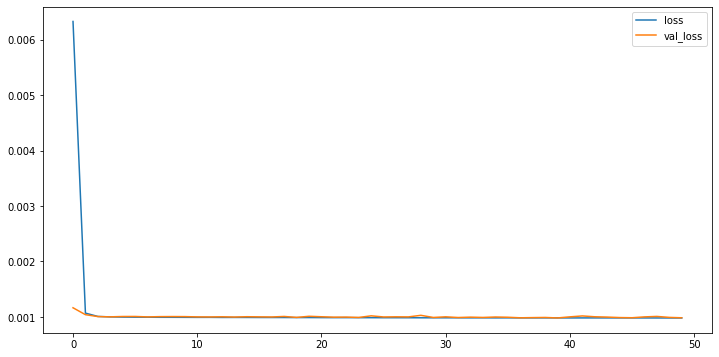

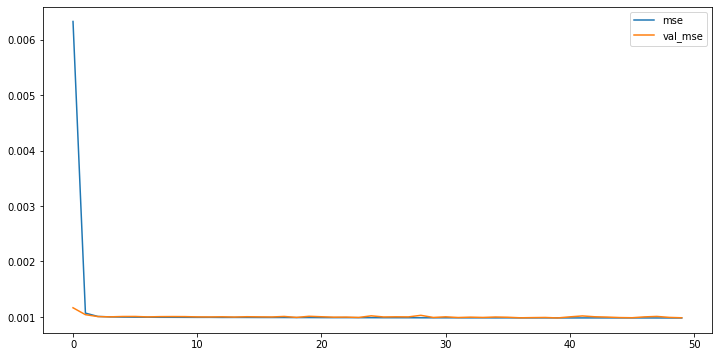

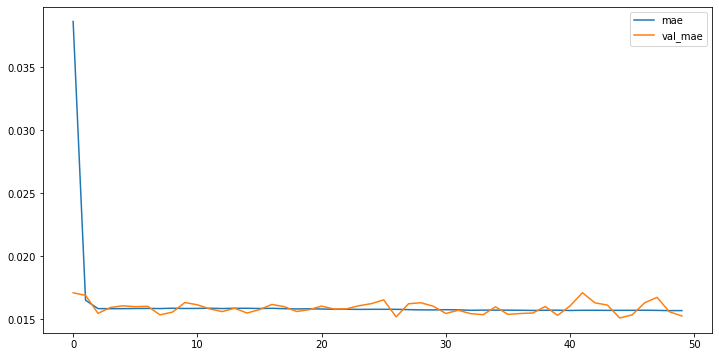

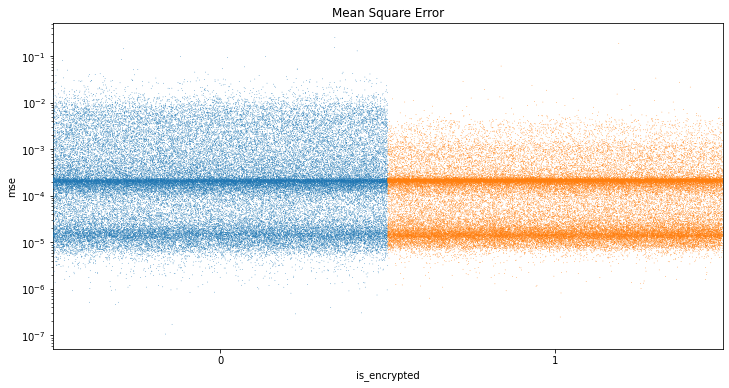

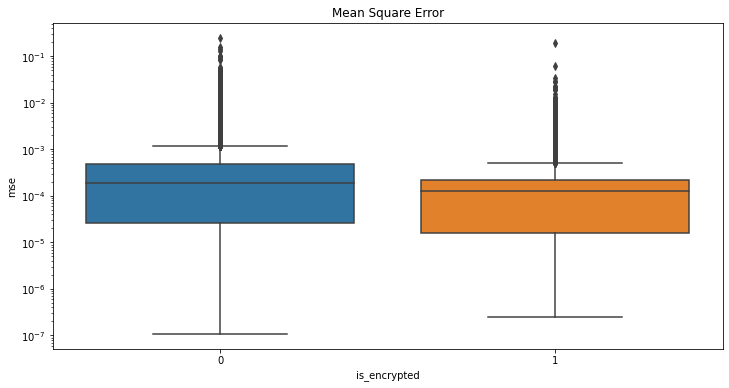





AUC Score for baseline is : 0.3990324977169831


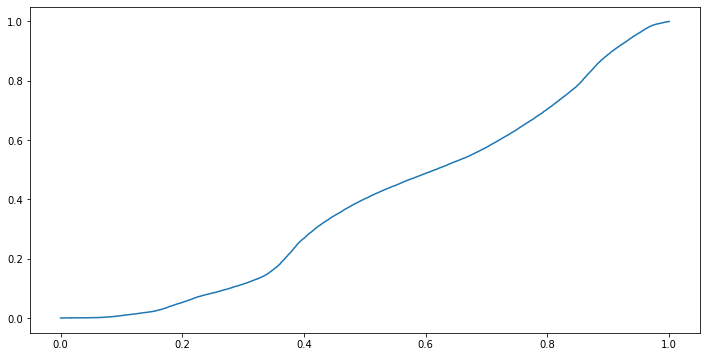

In [10]:
class Autoencoder_baseline:
    @staticmethod
    def build():
        model = tf.keras.Sequential(
            [
                layers.Dense(4, activation='relu'),
                layers.Dense(3, activation='relu'),
                layers.Dense(2, activation='relu'),
                layers.Dense(3, activation='relu'),
                layers.Dense(4, activation='relu'),
                layers.Dense(4, activation='sigmoid'),
            ]
        )
        return model


description, score = evaluate_model(Autoencoder_baseline.build(), all_column_names['baseline'], N_EPOCHS, "baseline")
auc_scores[description] = score

Number of features: 40
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 40)                1640      
                                                                 
 dropout_5 (Dropout)         (None, 40)                0         
                                                                 
 dense_20 (Dense)            (None, 30)                1230      
                                                                 
 dropout_6 (Dropout)         (None, 30)                0         
                                                                 
 dense_21 (Dense)            (None, 15)                465       
                                                                 
 dropout_7 (Dropout)         (None, 15)                0         
                                                                 
 dense_22 (Dense)            (N

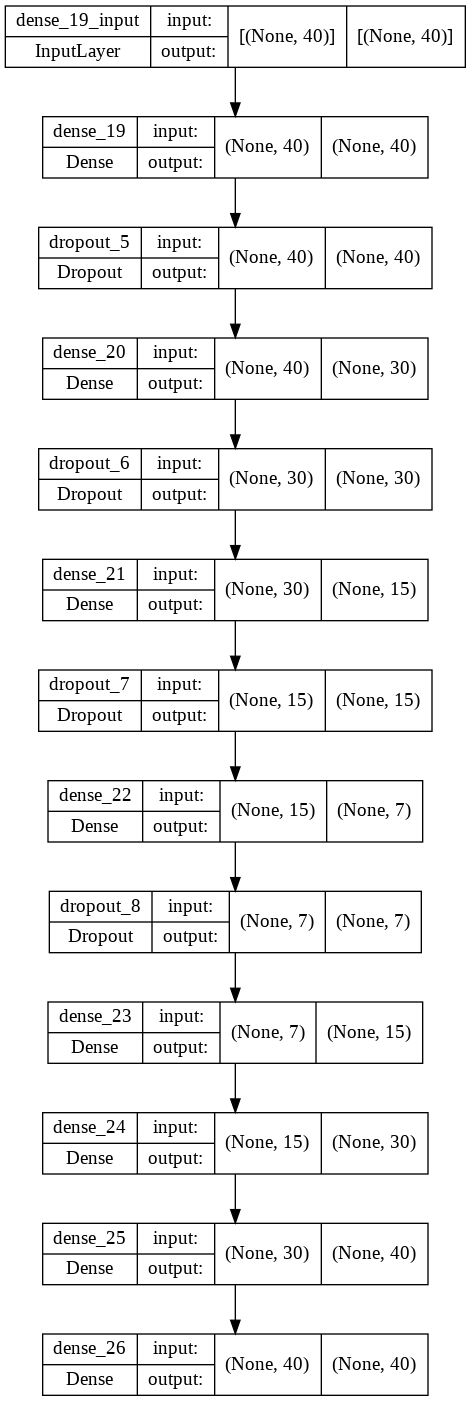

(206983, 40) (51746, 40)
Epoch 1/50
6469/6469 [==============================] - 23s 3ms/step - loss: 0.0045 - mae: 0.0308 - mse: 0.0045 - val_loss: 0.0016 - val_mae: 0.0213 - val_mse: 0.0016
Epoch 2/50
6469/6469 [==============================] - 22s 3ms/step - loss: 0.0015 - mae: 0.0173 - mse: 0.0015 - val_loss: 0.0011 - val_mae: 0.0181 - val_mse: 0.0011
Epoch 3/50
6469/6469 [==============================] - 22s 3ms/step - loss: 9.9223e-04 - mae: 0.0142 - mse: 9.9223e-04 - val_loss: 6.2043e-04 - val_mae: 0.0126 - val_mse: 6.2043e-04
Epoch 4/50
6469/6469 [==============================] - 22s 3ms/step - loss: 8.2293e-04 - mae: 0.0127 - mse: 8.2293e-04 - val_loss: 0.0012 - val_mae: 0.0168 - val_mse: 0.0012
Epoch 5/50
6469/6469 [==============================] - 23s 3ms/step - loss: 7.4249e-04 - mae: 0.0119 - mse: 7.4249e-04 - val_loss: 9.6631e-04 - val_mae: 0.0164 - val_mse: 9.6631e-04
Epoch 6/50
6469/6469 [==============================] - 22s 3ms/step - loss: 6.8701e-04 - mae: 0.011

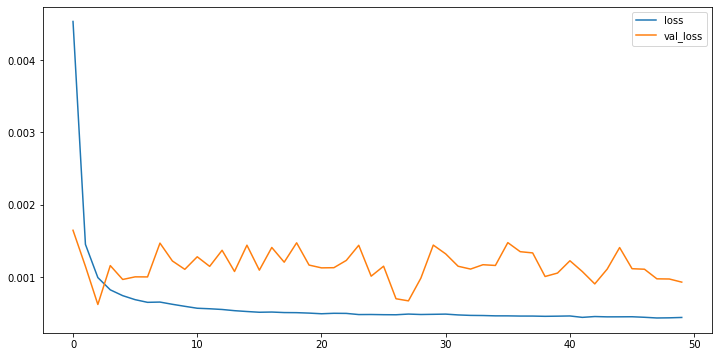

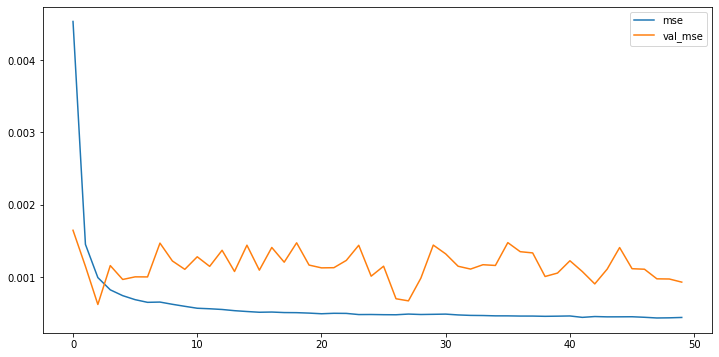

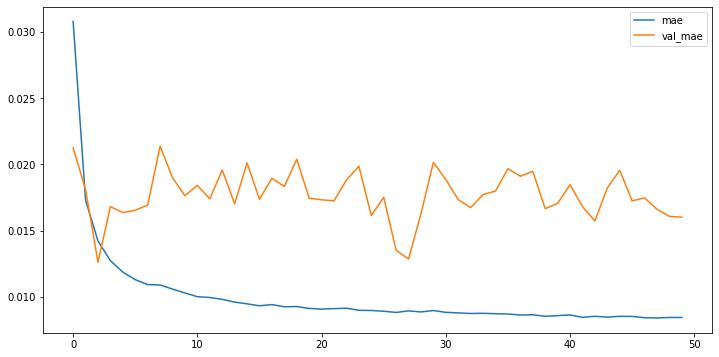

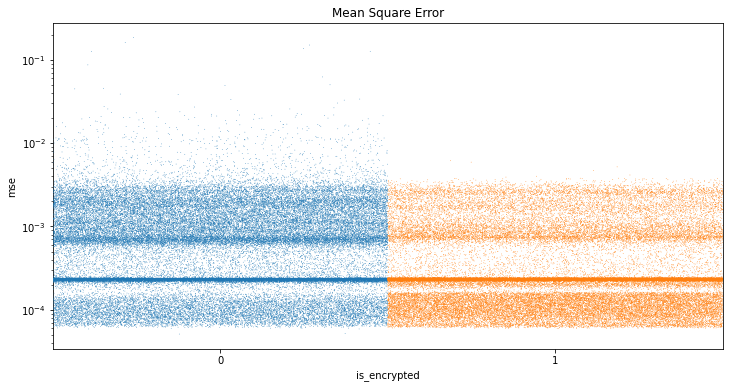

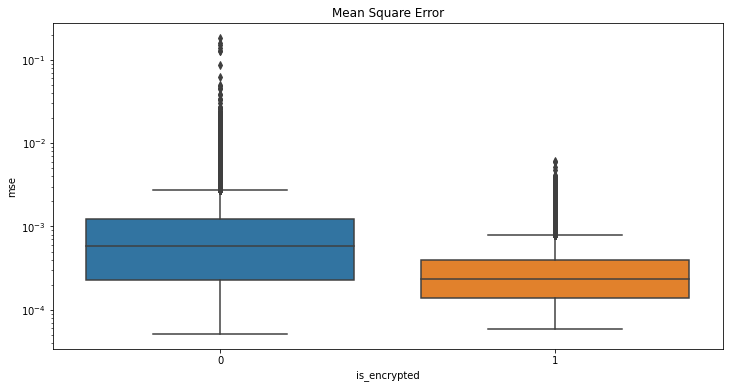





AUC Score for advanced-only is : 0.3537576394246776


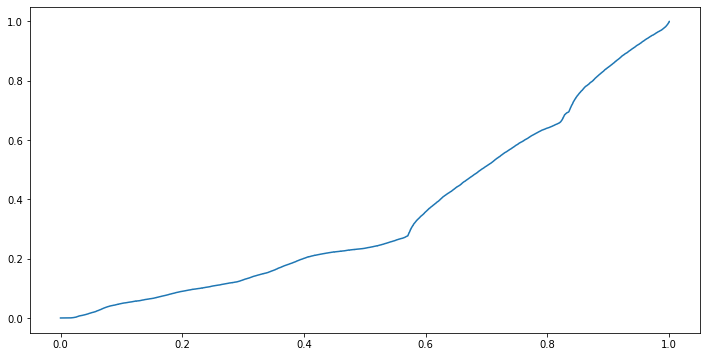

In [11]:
class Autoencoder_AdvancedOnly:
    @staticmethod
    def build():
        model = tf.keras.Sequential(
            [
                layers.Dense(40, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(30, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(15, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(7, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(15, activation='relu'),
                layers.Dense(30, activation='relu'),
                layers.Dense(40, activation='relu'),
                layers.Dense(40, activation='sigmoid'),
            ]
        )
        return model


gc_collect()
name = 'advanced-only'
description, score = evaluate_model(Autoencoder_AdvancedOnly.build(), all_column_names[name], N_EPOCHS, name)
auc_scores[description] = score

Number of features: 18
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 18)                342       
                                                                 
 dropout_9 (Dropout)         (None, 18)                0         
                                                                 
 dense_28 (Dense)            (None, 12)                228       
                                                                 
 dropout_10 (Dropout)        (None, 12)                0         
                                                                 
 dense_29 (Dense)            (None, 8)                 104       
                                                                 
 dropout_11 (Dropout)        (None, 8)                 0         
                                                                 
 dense_30 (Dense)            (N

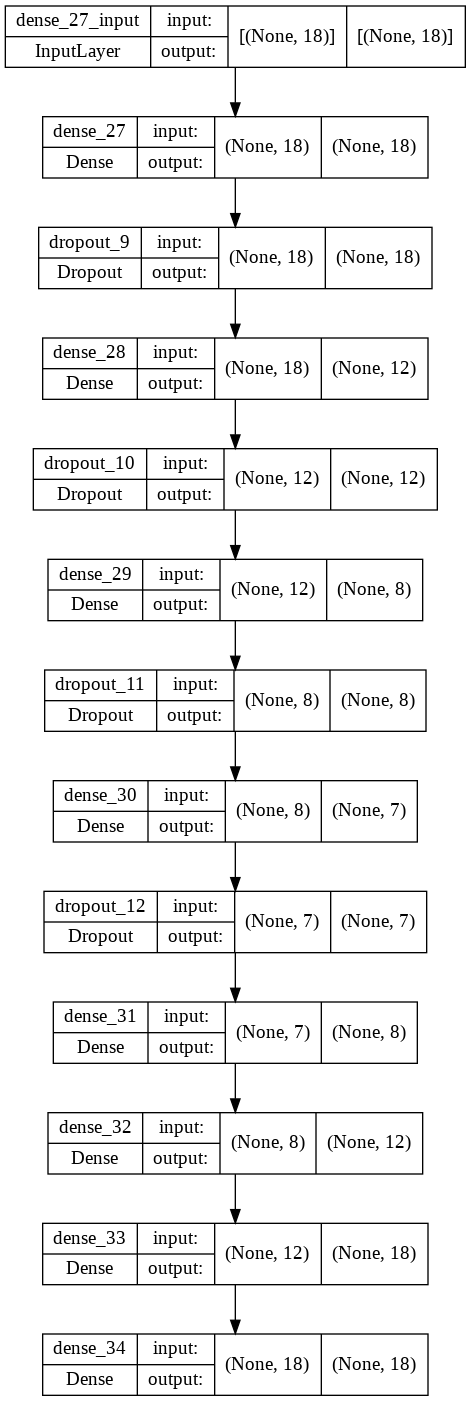

(206983, 18) (51746, 18)
Epoch 1/50
6469/6469 [==============================] - 23s 4ms/step - loss: 0.0044 - mae: 0.0166 - mse: 0.0044 - val_loss: 2.7646e-04 - val_mae: 0.0046 - val_mse: 2.7646e-04
Epoch 2/50
6469/6469 [==============================] - 22s 3ms/step - loss: 5.3420e-04 - mae: 0.0055 - mse: 5.3420e-04 - val_loss: 2.1652e-04 - val_mae: 0.0038 - val_mse: 2.1652e-04
Epoch 3/50
6469/6469 [==============================] - 22s 3ms/step - loss: 4.2863e-04 - mae: 0.0046 - mse: 4.2863e-04 - val_loss: 1.3528e-04 - val_mae: 0.0027 - val_mse: 1.3528e-04
Epoch 4/50
6469/6469 [==============================] - 23s 4ms/step - loss: 3.7604e-04 - mae: 0.0042 - mse: 3.7604e-04 - val_loss: 1.6561e-04 - val_mae: 0.0032 - val_mse: 1.6561e-04
Epoch 5/50
6469/6469 [==============================] - 22s 3ms/step - loss: 3.3999e-04 - mae: 0.0039 - mse: 3.3999e-04 - val_loss: 1.9004e-04 - val_mae: 0.0035 - val_mse: 1.9004e-04
Epoch 6/50
6469/6469 [==============================] - 22s 3ms/step

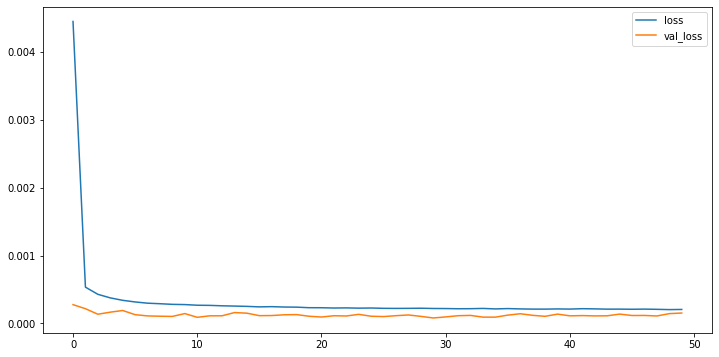

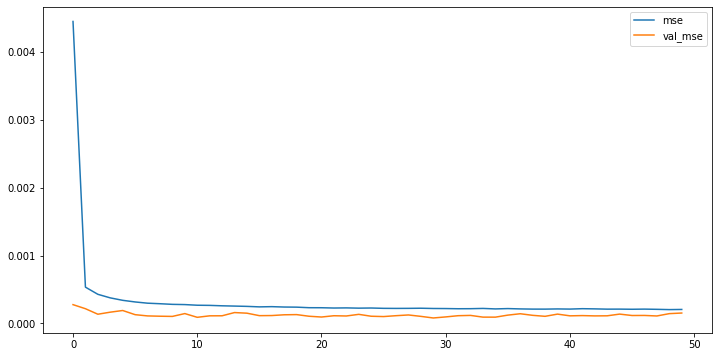

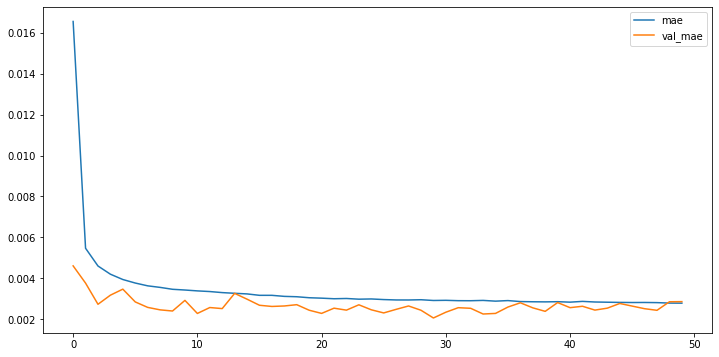

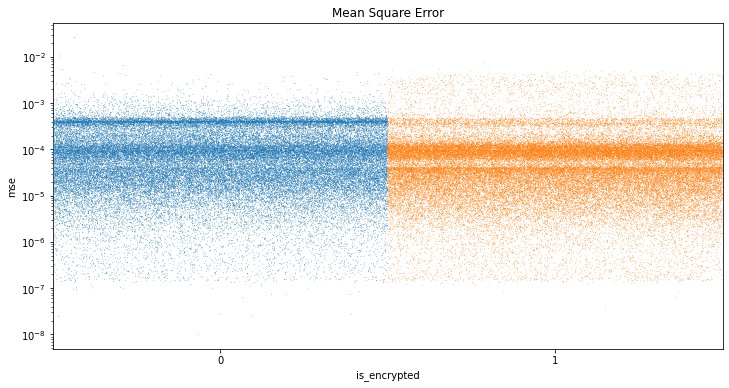

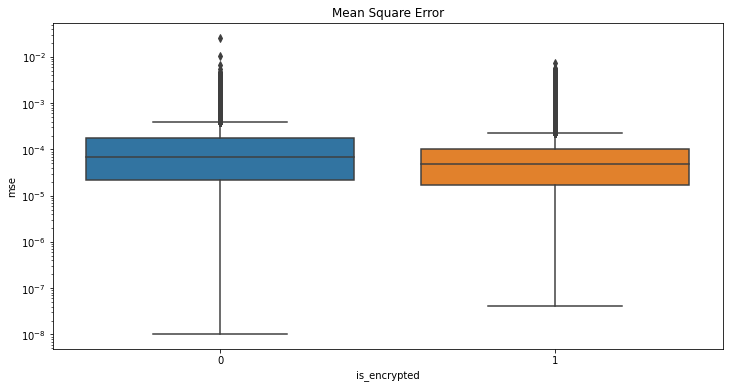





AUC Score for fourier-only is : 0.4294681929950485


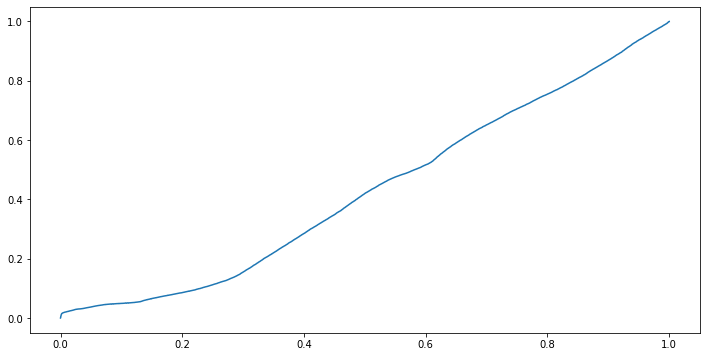

In [12]:
class Autoencoder_FourierOnly:
    @staticmethod
    def build():
        model = tf.keras.Sequential(
            [
                layers.Dense(18, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(12, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(8, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(7, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(8, activation='relu'),
                layers.Dense(12, activation='relu'),
                layers.Dense(18, activation='relu'),
                layers.Dense(18, activation='sigmoid'),
            ]
        )
        return model

gc_collect()
name = 'fourier-only'
description, score = evaluate_model(Autoencoder_FourierOnly.build(), all_column_names[name], N_EPOCHS, name)
auc_scores[description] = score

In [13]:
gc_collect()

Number of features: 44
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 44)                1980      
                                                                 
 dropout_13 (Dropout)        (None, 44)                0         
                                                                 
 dense_36 (Dense)            (None, 40)                1800      
                                                                 
 dropout_14 (Dropout)        (None, 40)                0         
                                                                 
 dense_37 (Dense)            (None, 30)                1230      
                                                                 
 dropout_15 (Dropout)        (None, 30)                0         
                                                                 
 dense_38 (Dense)            (N

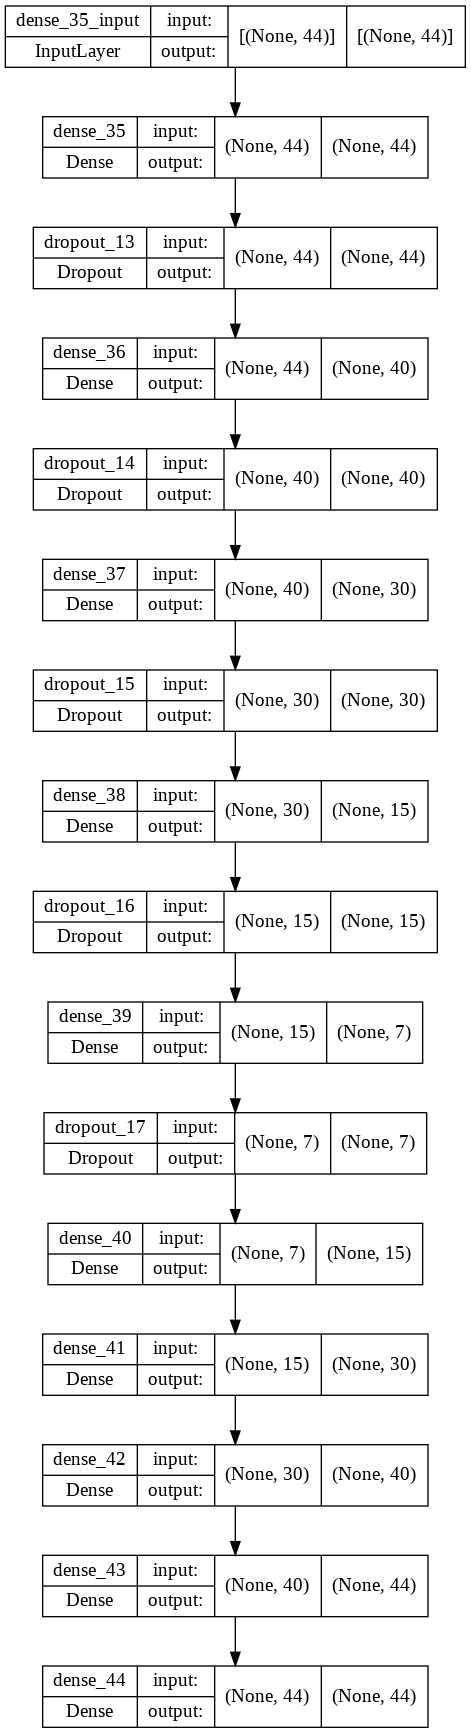

(206983, 44) (51746, 44)
Epoch 1/50
6469/6469 [==============================] - 26s 4ms/step - loss: 0.0045 - mae: 0.0305 - mse: 0.0045 - val_loss: 0.0050 - val_mae: 0.0409 - val_mse: 0.0050
Epoch 2/50
6469/6469 [==============================] - 25s 4ms/step - loss: 0.0018 - mae: 0.0189 - mse: 0.0018 - val_loss: 0.0059 - val_mae: 0.0420 - val_mse: 0.0059
Epoch 3/50
6469/6469 [==============================] - 25s 4ms/step - loss: 0.0015 - mae: 0.0169 - mse: 0.0015 - val_loss: 0.0052 - val_mae: 0.0395 - val_mse: 0.0052
Epoch 4/50
6469/6469 [==============================] - 25s 4ms/step - loss: 0.0015 - mae: 0.0165 - mse: 0.0015 - val_loss: 0.0077 - val_mae: 0.0475 - val_mse: 0.0077
Epoch 5/50
6469/6469 [==============================] - 25s 4ms/step - loss: 0.0014 - mae: 0.0158 - mse: 0.0014 - val_loss: 0.0056 - val_mae: 0.0405 - val_mse: 0.0056
Epoch 6/50
6469/6469 [==============================] - 25s 4ms/step - loss: 0.0016 - mae: 0.0163 - mse: 0.0016 - val_loss: 0.0056 - val_mae

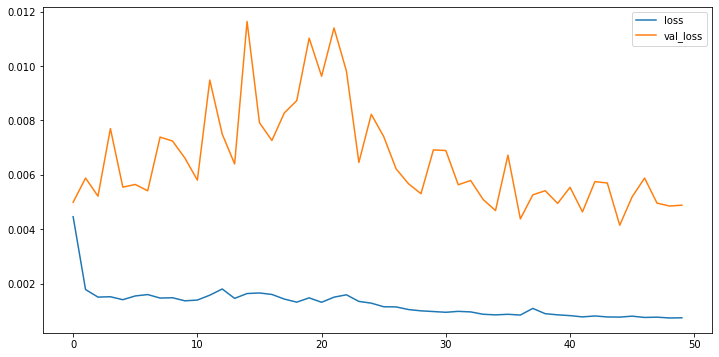

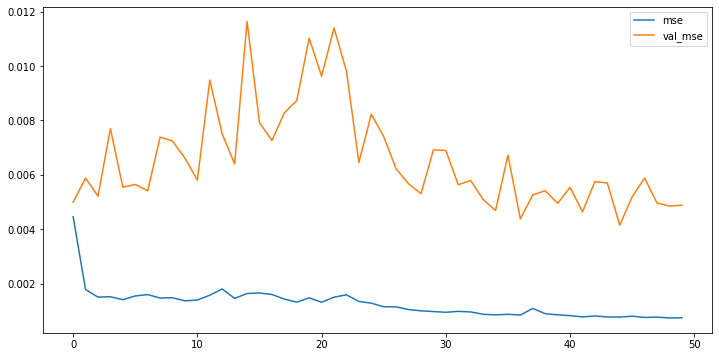

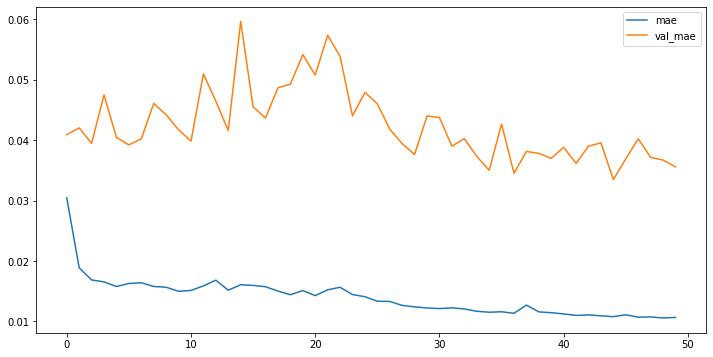

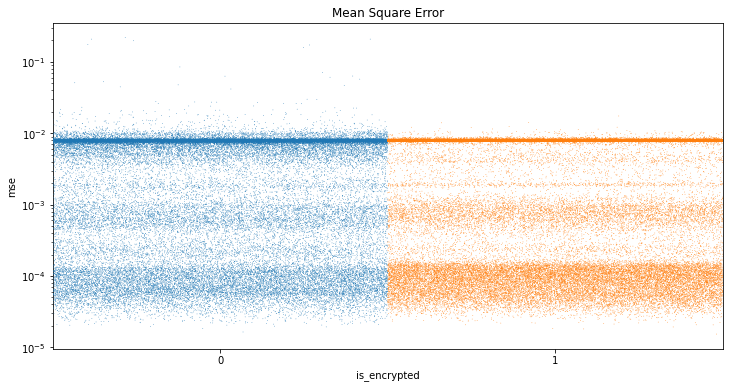

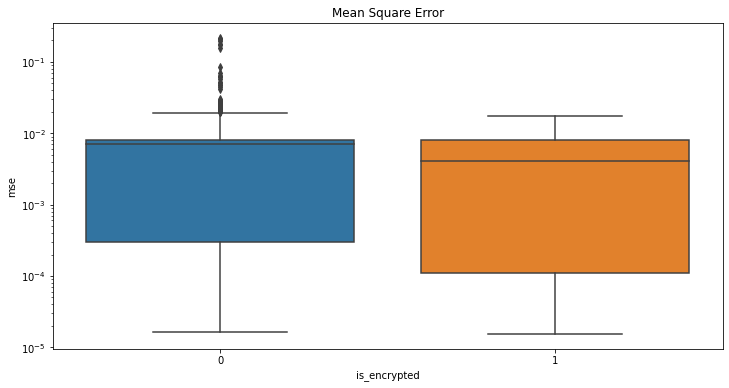





AUC Score for baseline-and-advanced is : 0.4520431949575342


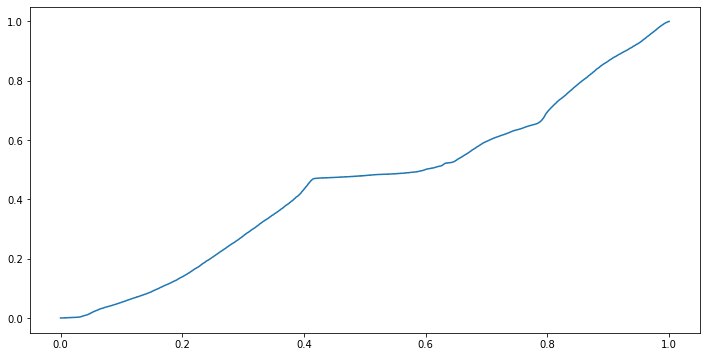

In [14]:
class Autoencoder_BaselineAndAdvanced:
    @staticmethod
    def build():
        model = tf.keras.Sequential(
            [
                layers.Dense(44, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(40, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(30, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(15, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(7, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(15, activation='relu'),
                layers.Dense(30, activation='relu'),
                layers.Dense(40, activation='relu'),
                layers.Dense(44, activation='relu'),
                layers.Dense(44, activation='sigmoid'),
            ]
        )
        return model

gc_collect()
name = 'advanced'
description, score = evaluate_model(Autoencoder_BaselineAndAdvanced.build(), all_column_names[name], N_EPOCHS, "baseline-and-advanced")
auc_scores[description] = score

In [15]:
all_column_names.keys()

dict_keys(['baseline', 'advanced-only', 'fourier-only', 'baseline-and-fourier', 'advanced-and-fourier', 'advanced', 'fourier', 'all_columns'])

Number of features: 22
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 22)                506       
                                                                 
 dropout_18 (Dropout)        (None, 22)                0         
                                                                 
 dense_46 (Dense)            (None, 15)                345       
                                                                 
 dropout_19 (Dropout)        (None, 15)                0         
                                                                 
 dense_47 (Dense)            (None, 10)                160       
                                                                 
 dropout_20 (Dropout)        (None, 10)                0         
                                                                 
 dense_48 (Dense)            (N

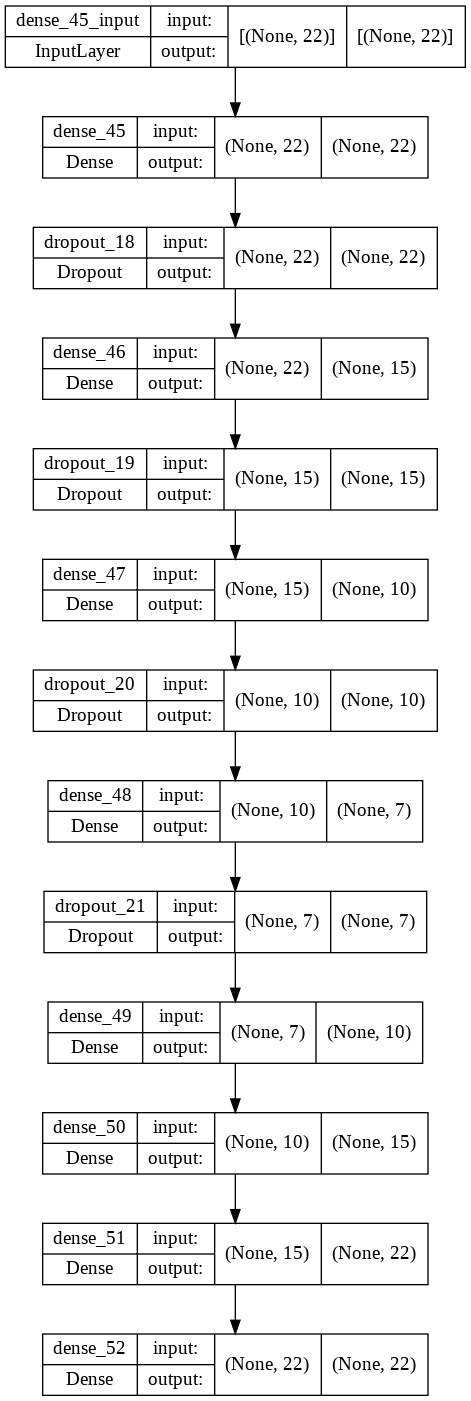

(206983, 22) (51746, 22)
Epoch 1/50
6469/6469 [==============================] - 24s 4ms/step - loss: 0.0058 - mae: 0.0260 - mse: 0.0058 - val_loss: 0.0014 - val_mae: 0.0114 - val_mse: 0.0014
Epoch 2/50
6469/6469 [==============================] - 23s 4ms/step - loss: 0.0014 - mae: 0.0110 - mse: 0.0014 - val_loss: 0.0015 - val_mae: 0.0116 - val_mse: 0.0015
Epoch 3/50
6469/6469 [==============================] - 23s 4ms/step - loss: 0.0012 - mae: 0.0102 - mse: 0.0012 - val_loss: 0.0013 - val_mae: 0.0113 - val_mse: 0.0013
Epoch 4/50
6469/6469 [==============================] - 23s 3ms/step - loss: 0.0011 - mae: 0.0097 - mse: 0.0011 - val_loss: 0.0014 - val_mae: 0.0116 - val_mse: 0.0014
Epoch 5/50
6469/6469 [==============================] - 23s 4ms/step - loss: 0.0011 - mae: 0.0094 - mse: 0.0011 - val_loss: 0.0014 - val_mae: 0.0109 - val_mse: 0.0014
Epoch 6/50
6469/6469 [==============================] - 23s 4ms/step - loss: 0.0010 - mae: 0.0092 - mse: 0.0010 - val_loss: 0.0014 - val_mae

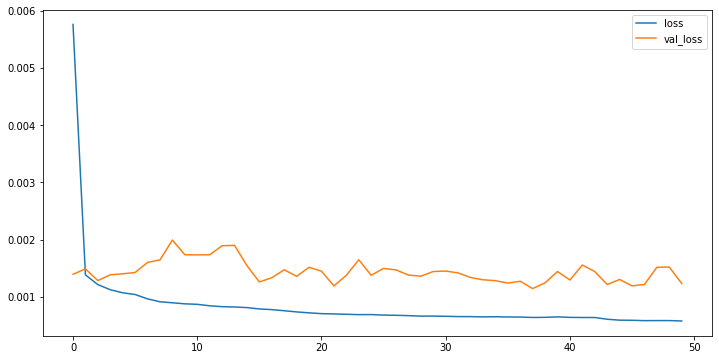

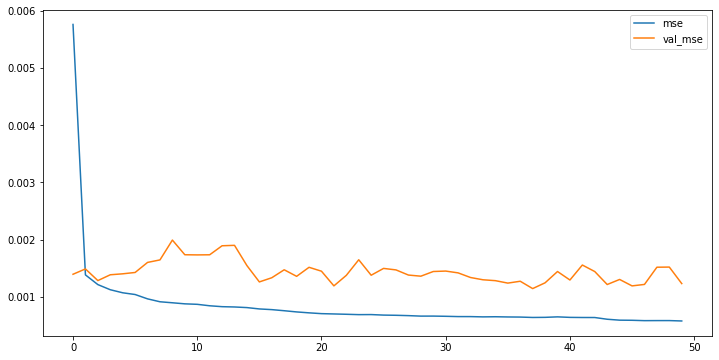

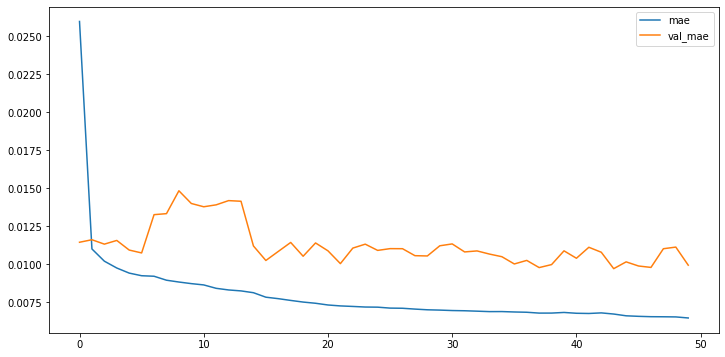

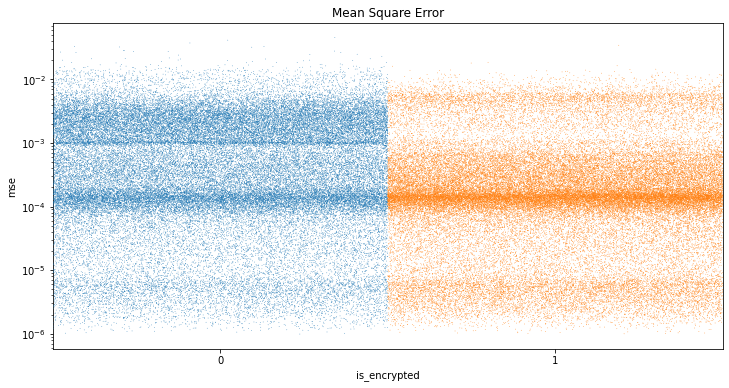

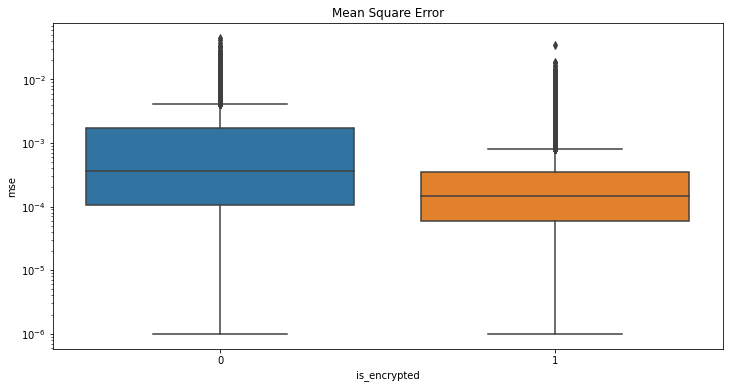





AUC Score for baseline-and-fourier is : 0.3687208831244341


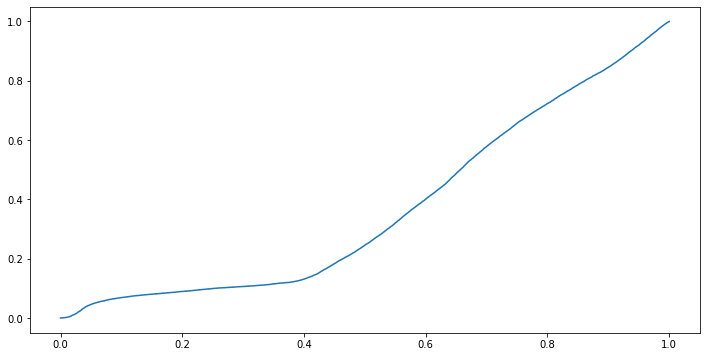

In [16]:
class Autoencoder_BaselineAndFourier:
    @staticmethod
    def build():
        model = tf.keras.Sequential(
            [
                layers.Dense(22, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(15, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(10, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(7, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(10, activation='relu'),
                layers.Dense(15, activation='relu'),
                layers.Dense(22, activation='relu'),
                layers.Dense(22, activation='sigmoid'),
            ]
        )
        return model

gc_collect()
name = 'baseline-and-fourier'
description, score = evaluate_model(Autoencoder_BaselineAndFourier.build(), all_column_names[name], N_EPOCHS, name)
auc_scores[description] = score

Number of features: 58
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_53 (Dense)            (None, 58)                3422      
                                                                 
 dropout_22 (Dropout)        (None, 58)                0         
                                                                 
 dense_54 (Dense)            (None, 50)                2950      
                                                                 
 dropout_23 (Dropout)        (None, 50)                0         
                                                                 
 dense_55 (Dense)            (None, 25)                1275      
                                                                 
 dropout_24 (Dropout)        (None, 25)                0         
                                                                 
 dense_56 (Dense)            (N

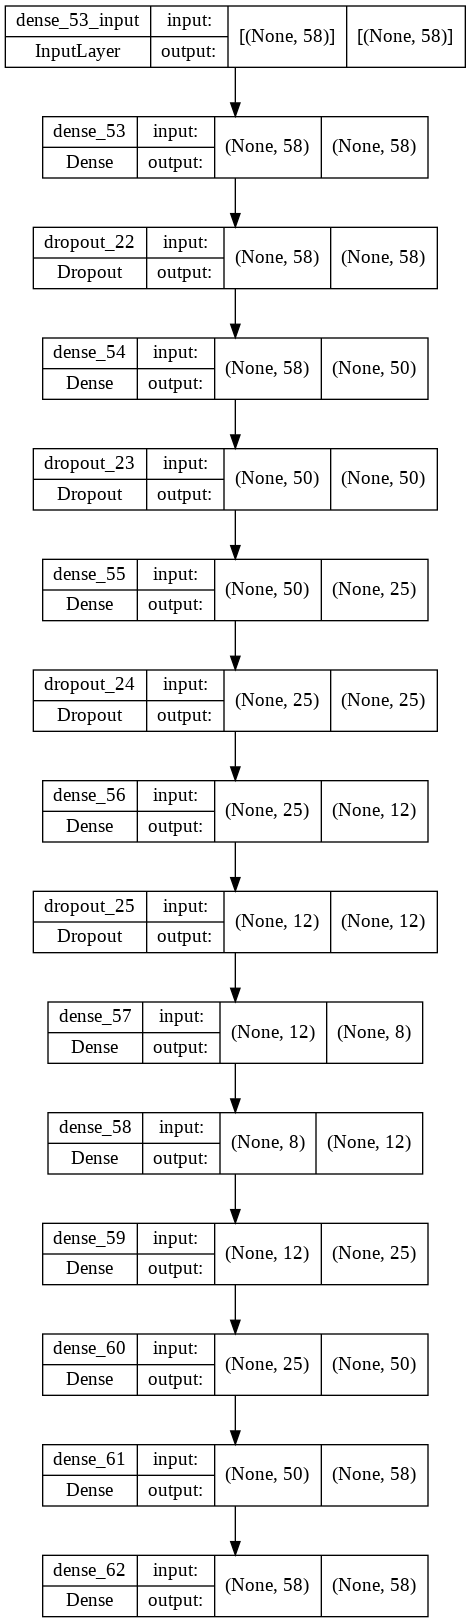

(206983, 58) (51746, 58)
Epoch 1/50
6469/6469 [==============================] - 25s 4ms/step - loss: 0.0032 - mae: 0.0210 - mse: 0.0032 - val_loss: 7.0659e-04 - val_mae: 0.0117 - val_mse: 7.0659e-04
Epoch 2/50
6469/6469 [==============================] - 24s 4ms/step - loss: 7.5880e-04 - mae: 0.0107 - mse: 7.5880e-04 - val_loss: 7.0144e-04 - val_mae: 0.0112 - val_mse: 7.0144e-04
Epoch 3/50
6469/6469 [==============================] - 24s 4ms/step - loss: 6.2079e-04 - mae: 0.0093 - mse: 6.2079e-04 - val_loss: 6.4960e-04 - val_mae: 0.0107 - val_mse: 6.4960e-04
Epoch 4/50
6469/6469 [==============================] - 24s 4ms/step - loss: 5.6403e-04 - mae: 0.0086 - mse: 5.6403e-04 - val_loss: 7.3173e-04 - val_mae: 0.0112 - val_mse: 7.3173e-04
Epoch 5/50
6469/6469 [==============================] - 24s 4ms/step - loss: 5.3379e-04 - mae: 0.0082 - mse: 5.3379e-04 - val_loss: 7.1165e-04 - val_mae: 0.0109 - val_mse: 7.1165e-04
Epoch 6/50
6469/6469 [==============================] - 24s 4ms/step

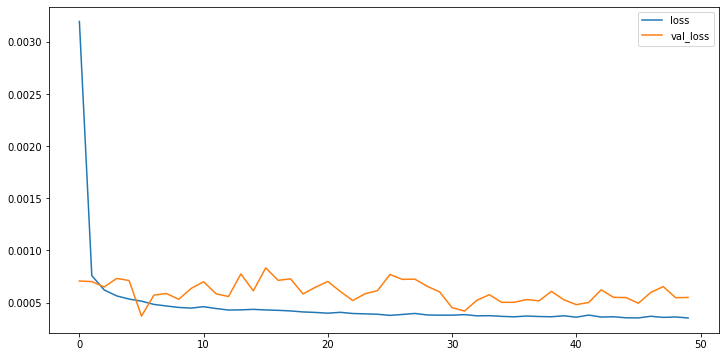

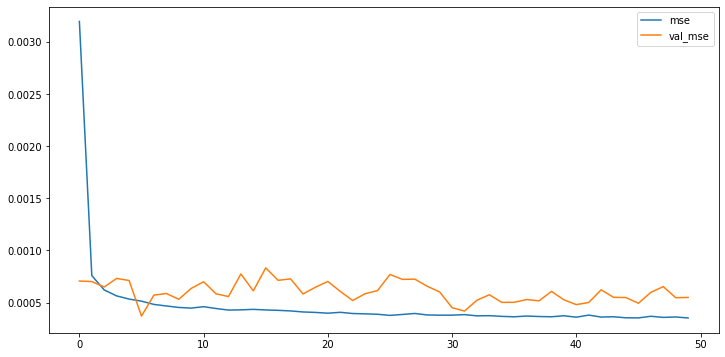

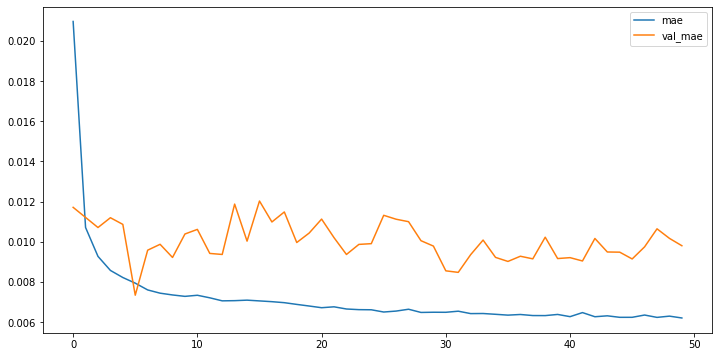

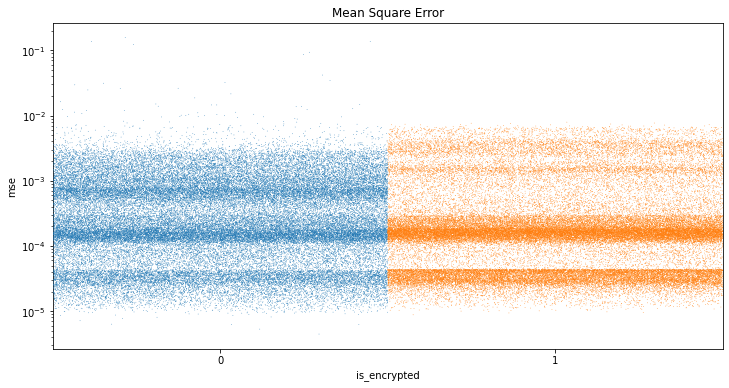

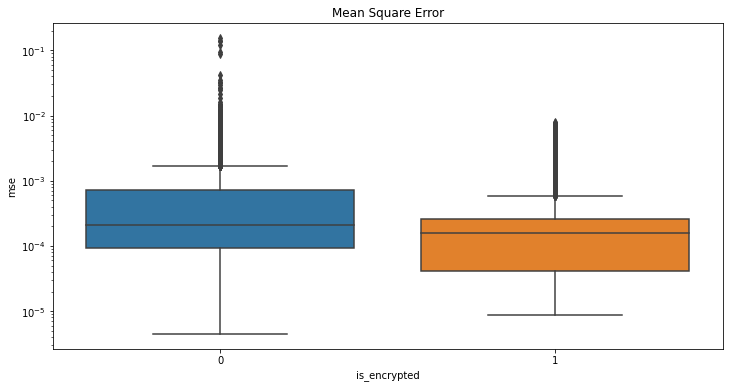





AUC Score for advanced-and-fourier is : 0.4265818282510979


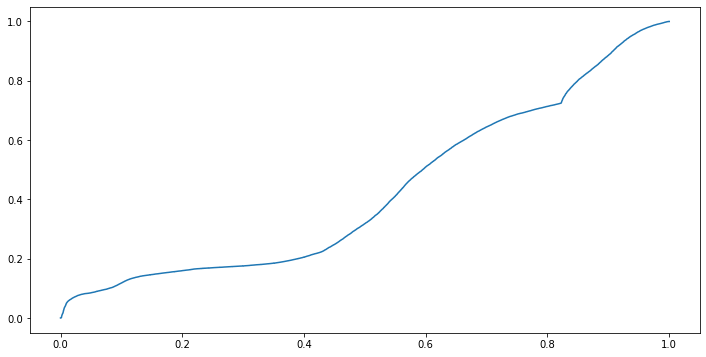

In [17]:
class Autoencoder_AdvancedAndFourier:
    @staticmethod
    def build():
        model = tf.keras.Sequential(
            [
                layers.Dense(58, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(50, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(25, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(12, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(8, activation='relu'),
                layers.Dense(12, activation='relu'),
                layers.Dense(25, activation='relu'),
                layers.Dense(50, activation='relu'),
                layers.Dense(58, activation='relu'),
                layers.Dense(58, activation='sigmoid'),
            ]
        )
        return model

gc_collect()
name = 'advanced-and-fourier'
description, score = evaluate_model(Autoencoder_AdvancedAndFourier.build(), all_column_names[name], N_EPOCHS, name)
auc_scores[description] = score

Number of features: 62
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 62)                3906      
                                                                 
 dropout_26 (Dropout)        (None, 62)                0         
                                                                 
 dense_64 (Dense)            (None, 55)                3465      
                                                                 
 dropout_27 (Dropout)        (None, 55)                0         
                                                                 
 dense_65 (Dense)            (None, 50)                2800      
                                                                 
 dropout_28 (Dropout)        (None, 50)                0         
                                                                 
 dense_66 (Dense)            (N

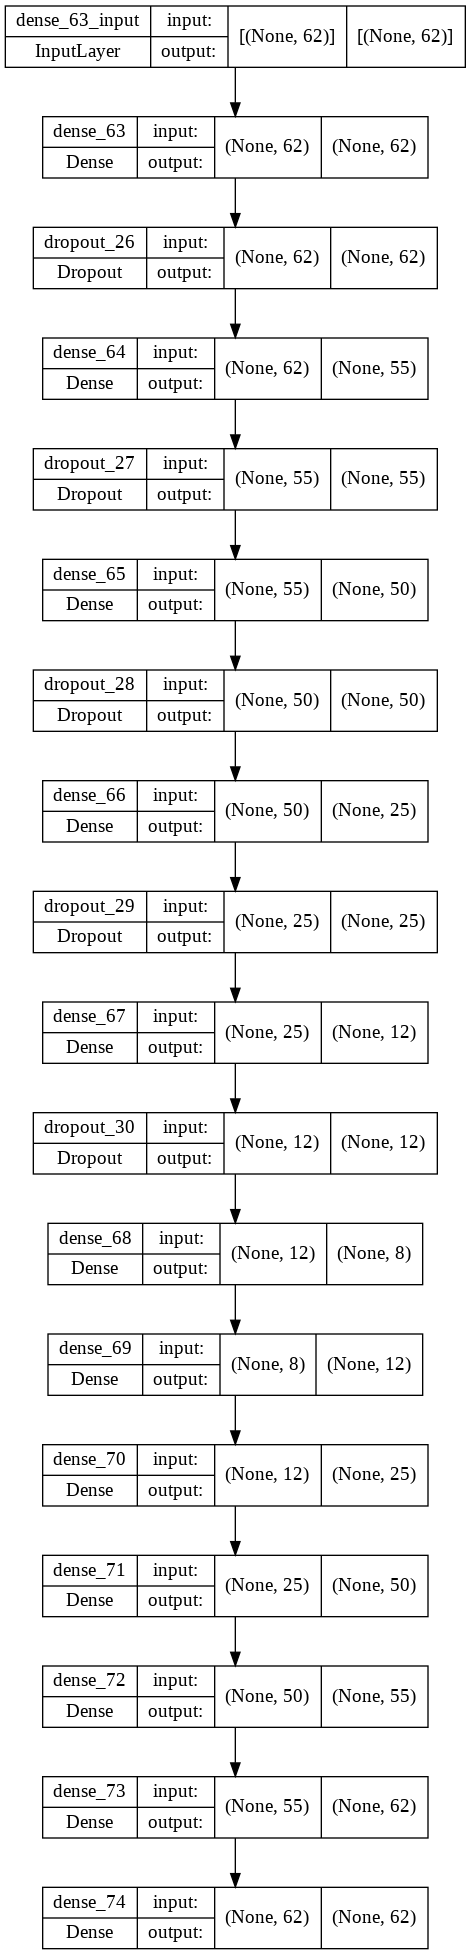

(206983, 62) (51746, 62)
Epoch 1/50
6469/6469 [==============================] - 27s 4ms/step - loss: 0.0046 - mae: 0.0267 - mse: 0.0046 - val_loss: 0.0017 - val_mae: 0.0177 - val_mse: 0.0017
Epoch 2/50
6469/6469 [==============================] - 25s 4ms/step - loss: 0.0012 - mae: 0.0140 - mse: 0.0012 - val_loss: 0.0016 - val_mae: 0.0173 - val_mse: 0.0016
Epoch 3/50
6469/6469 [==============================] - 25s 4ms/step - loss: 8.6716e-04 - mae: 0.0113 - mse: 8.6716e-04 - val_loss: 0.0016 - val_mae: 0.0186 - val_mse: 0.0016
Epoch 4/50
6469/6469 [==============================] - 25s 4ms/step - loss: 7.5359e-04 - mae: 0.0102 - mse: 7.5359e-04 - val_loss: 0.0012 - val_mae: 0.0145 - val_mse: 0.0012
Epoch 5/50
6469/6469 [==============================] - 26s 4ms/step - loss: 6.8143e-04 - mae: 0.0096 - mse: 6.8143e-04 - val_loss: 0.0012 - val_mae: 0.0147 - val_mse: 0.0012
Epoch 6/50
6469/6469 [==============================] - 26s 4ms/step - loss: 6.4041e-04 - mae: 0.0092 - mse: 6.4041e

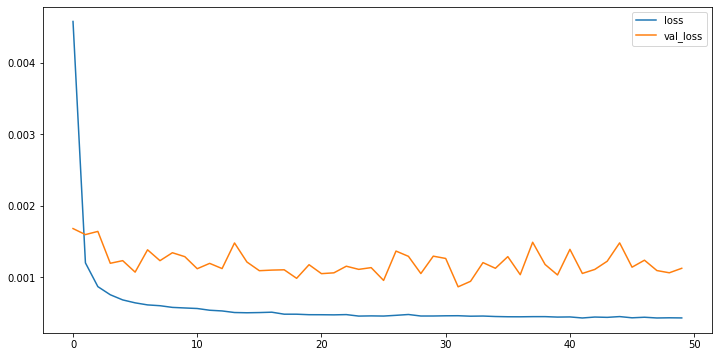

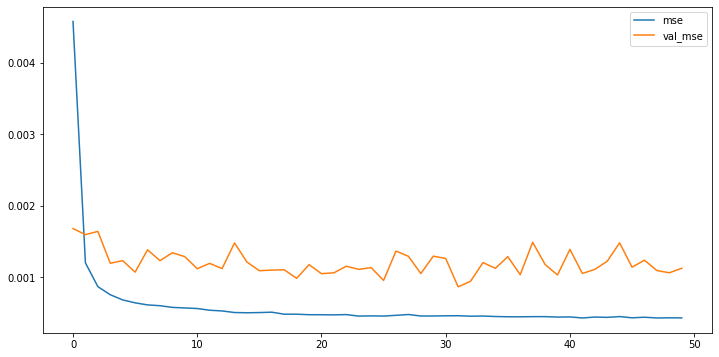

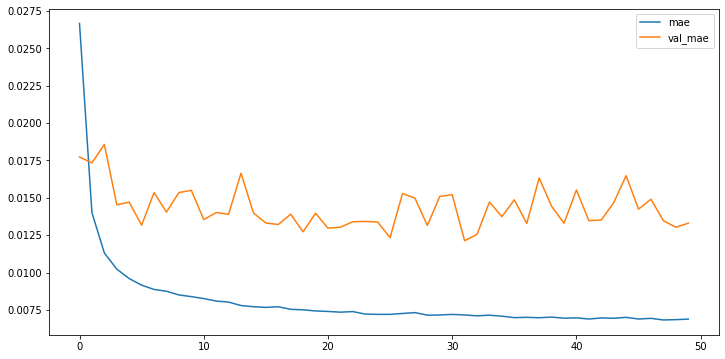

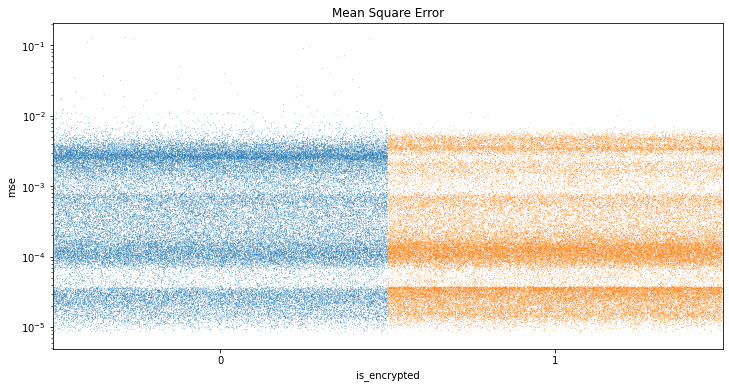

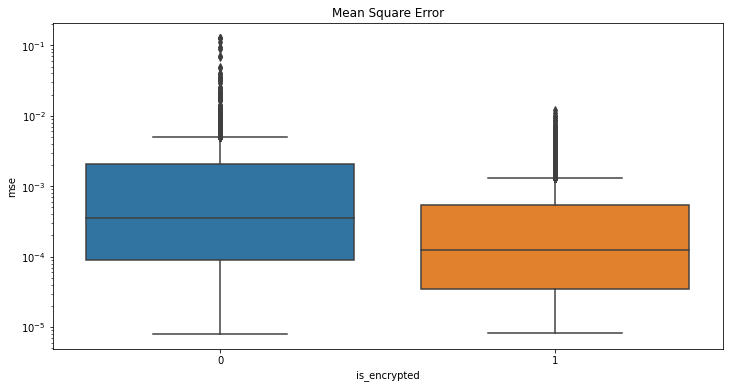





AUC Score for baseline-advanced-and-fourier is : 0.3906812664665803


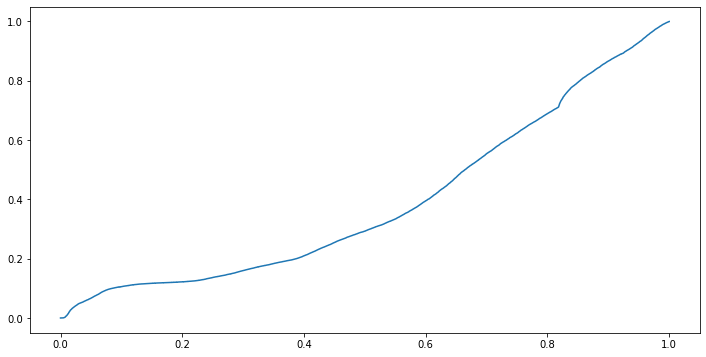

In [18]:
class Autoencoder_BaselineAdvancedAndFourier:
    @staticmethod
    def build():
        model = tf.keras.Sequential(
            [
                layers.Dense(62, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(55, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(50, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(25, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(12, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(8, activation='relu'),
                layers.Dense(12, activation='relu'),
                layers.Dense(25, activation='relu'),
                layers.Dense(50, activation='relu'),
                layers.Dense(55, activation='relu'),
                layers.Dense(62, activation='relu'),
                layers.Dense(62, activation='sigmoid'),
            ]
        )
        return model

gc_collect()
name = 'fourier'
description, score = evaluate_model(Autoencoder_BaselineAdvancedAndFourier.build(), all_column_names[name], N_EPOCHS, "baseline-advanced-and-fourier")
auc_scores[description] = score

In [19]:
print(auc_scores)

{'All columns': 0.6366761240533033, 'baseline': 0.3990324977169831, 'advanced-only': 0.3537576394246776, 'fourier-only': 0.4294681929950485, 'baseline-and-advanced': 0.4520431949575342, 'baseline-and-fourier': 0.3687208831244341, 'advanced-and-fourier': 0.4265818282510979, 'baseline-advanced-and-fourier': 0.3906812664665803}


In [20]:
for k, v in auc_scores.items():
    print(k, v)

All columns 0.6366761240533033
baseline 0.3990324977169831
advanced-only 0.3537576394246776
fourier-only 0.4294681929950485
baseline-and-advanced 0.4520431949575342
baseline-and-fourier 0.3687208831244341
advanced-and-fourier 0.4265818282510979
baseline-advanced-and-fourier 0.3906812664665803


In [21]:
keys = [k for k in auc_scores.keys()]
auc = [a for a in auc_scores.values()]

def rename_feature(x):
    out = ""
    last_char = None
    for c in x:
        if last_char is None:
            c = c.upper()
            last_char = c
        elif last_char == '-':
            c = c.upper()
            last_char = c
        elif c == '-':
            last_char = c
            c = ' '
        elif last_char == ' ':
            c = c.upper()
            last_char = c
        else:
            last_char = c
        out += c
    return out
        

df = pd.DataFrame({"Feature Set": keys, "AUC": auc}).sort_values(by="AUC", ascending=False).reset_index(drop=True)
df["Feature Set"] = df["Feature Set"].map(rename_feature)

df

Feature Set       AUC
0                    All Columns  0.636676
1          Baseline And Advanced  0.452043
2                   Fourier Only  0.429468
3           Advanced And Fourier  0.426582
4                       Baseline  0.399032
5  Baseline Advanced And Fourier  0.390681
6           Baseline And Fourier  0.368721
7                  Advanced Only  0.353758

In [22]:
print(df.to_latex())

\begin{tabular}{llr}
\toprule
{} &                    Feature Set &       AUC \\
\midrule
0 &                    All Columns &  0.636676 \\
1 &          Baseline And Advanced &  0.452043 \\
2 &                   Fourier Only &  0.429468 \\
3 &           Advanced And Fourier &  0.426582 \\
4 &                       Baseline &  0.399032 \\
5 &  Baseline Advanced And Fourier &  0.390681 \\
6 &           Baseline And Fourier &  0.368721 \\
7 &                  Advanced Only &  0.353758 \\
\bottomrule
\end{tabular}

